**6장 - 앙상블 학습과 랜덤 포레스트**

# 설정

이 프로젝트에는 파이썬 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

또한 사이킷런 ≥ 1.0.1이 필요합니다:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

이전 챕터에서와 마찬가지로 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


그리고 아직 존재하지 않는 경우 `images/ensembles` 폴더를 만들고, 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 투표 기반 분류기

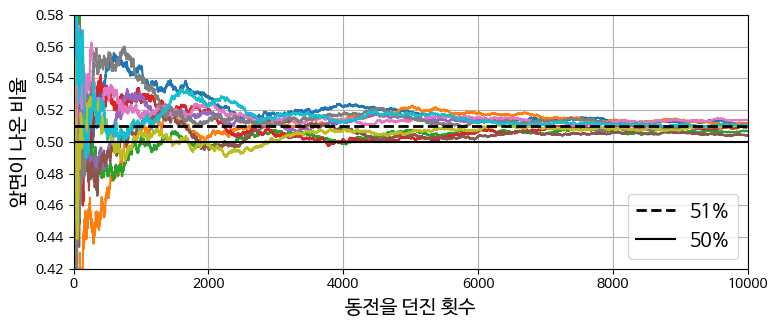

In [5]:
# 추가 코드 - 이 셀은 그림 7-3을 생성하고 저장합니다.

import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("동전을 던진 횟수")
plt.ylabel("앞면이 나온 비율")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

투표 기반 분류기를 만들어 보겠습니다:

In [6]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [8]:
voting_clf.predict(X_test[:1])

array([1])

In [9]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [10]:
voting_clf.score(X_test, y_test)

0.912

이제 간접 투표를 사용해 보겠습니다:

In [11]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# 배깅과 페이스팅
## 사이킷런의 배깅과 페이스팅

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

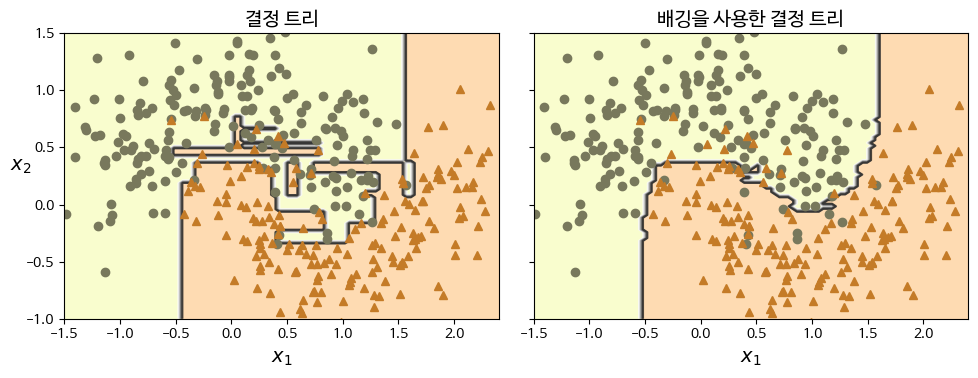

In [13]:
# 추가 코드 - 이 셀은 그림 7-5를 생성하고 저장합니다.

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("결정 트리")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("배깅을 사용한 결정 트리")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## OOB 평가

In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [15]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [16]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

크기가 _m_인 데이터셋에서 하나의 샘플을 무작위로 뽑는 경우, 데이터셋의 각 샘플이 선택될 확률은 1/_m_ 이므로 선택되지 않을 확률은 1 - 1/_m_ 입니다. 중복을 허용하여 _m_ 개의 샘플을 뽑는 경우, 모든 추첨은 독립적이므로 각 샘플의 선택되지 않을 확률은 (1 - 1/_m_)<sup>_m_</sup> 입니다. 이제 _m_ 이 무한대에 가까워지면 exp(_x_)가 (1 + _x_/_m_)<sup>_m_</sup>의 극한과 같다는 사실을 이용해 보겠습니다. 따라서 _m_ 이 크면 OOB 샘플의 비율은 약 exp(-1) ≈ 0.37이 됩니다. 따라서 대략 63%(1 - 0.37)가 샘플링됩니다.

In [17]:
# 추가 코드 - 63% 확률을 계산하는 방법을 보여줍니다.
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


# 랜덤 포레스트

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트는 결정 트리의 배깅과 같습니다:

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [20]:
# 추가 코드 - 예측이 동일한지 확인합니다.
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # 동일한 예측

np.True_

## 특성 중요도

In [21]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


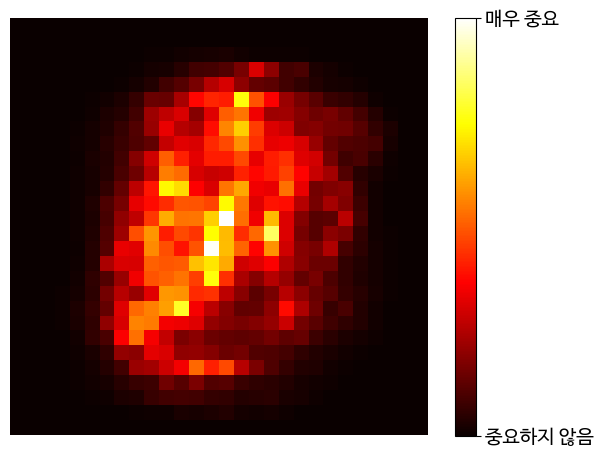

In [22]:
# 추가 코드 - 이 셀은 그림 7-6을 생성하고 저장합니다.

from sklearn.datasets import fetch_openml

# 사이킷런 1.4버전에서 parser 매개변수 기본값이 'liac-arff'에서 'auto'로 바뀌었습니다.
# 이전 버전에서도 동일한 결과를 내도록 명시적으로 'auto'로 지정합니다.
X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True,
                                as_frame=False, parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['중요하지 않음', '매우 중요'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

In [23]:
from sklearn.datasets import fetch_openml

# 사이킷런 1.4버전에서 parser 매개변수 기본값이 'liac-arff'에서 'auto'로 바뀌었습니다.
# 이전 버전에서도 동일한 결과를 내도록 명시적으로 'auto'로 지정합니다.
X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True,
                                as_frame=False, parser='auto')

# 부스팅
## AdaBoost

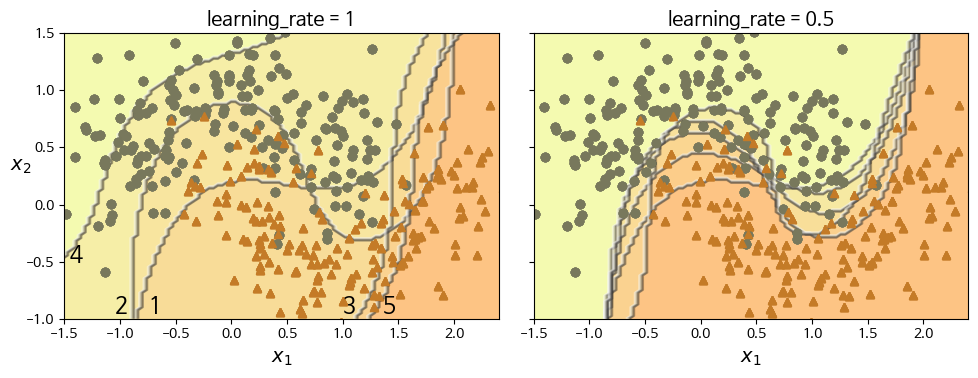

In [24]:
# 추가 코드 - 이 셀은 그림 7-8을 생성하고 저장합니다.

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [25]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

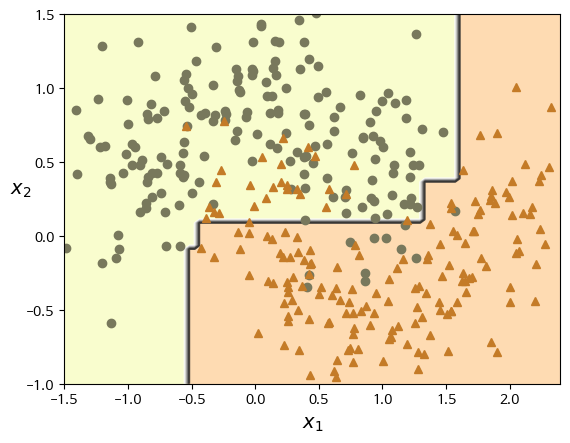

In [26]:
# 추가 코드 - AdaBoost 분류기에 대한 결정 경계가 어떻게 보이는지 궁금한 경우
plot_decision_boundary(ada_clf, X_train, y_train)

## 그레이디언트 부스팅

간단한 2차방정식 데이터셋을 만들고 여기에 `DecisionTreeRegressor`를 훈련시켜 보겠습니다:

In [27]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

이제 이전 예측기가 만든 잔여 오차에 대해 다른 결정 트리 회귀를 훈련해 보겠습니다:

In [28]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [29]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [30]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

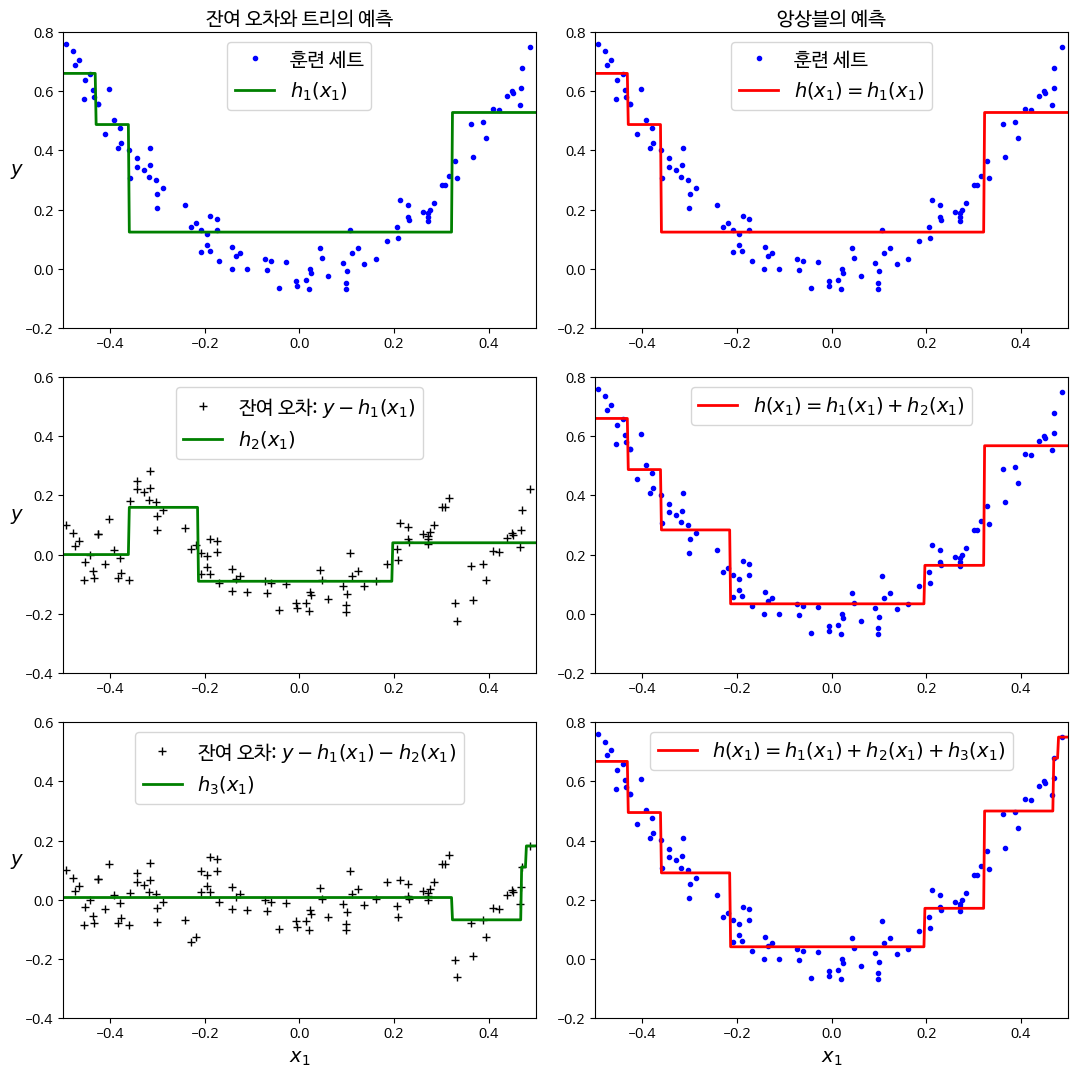

In [31]:
# 추가 코드 - 이 셀은 그림 7-9를 생성하고 저장합니다.

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$  ", rotation=0)
plt.title("잔여 오차와 트리의 예측")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.title("앙상블의 예측")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

이제 그레이디언트 부스팅 회귀를 시도해 보겠습니다:

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [33]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [34]:
gbrt_best.n_estimators_

92

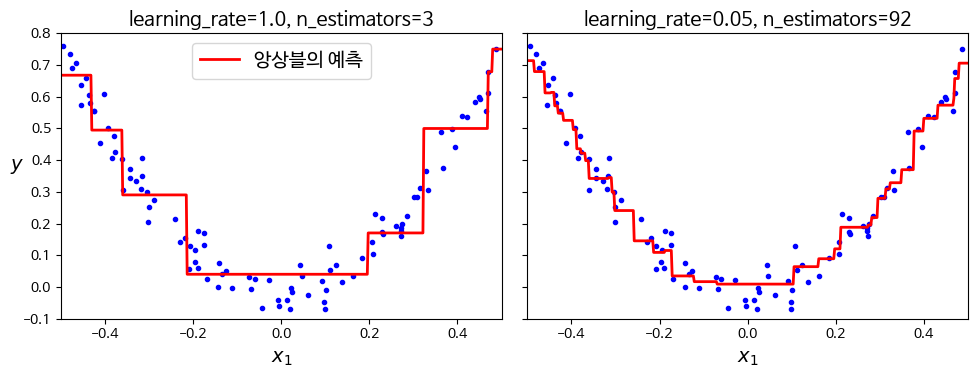

In [35]:
# 추가 코드 - 이 셀은 그림 7-10을 생성하고 저장합니다.

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="앙상블의 예측")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")
plt.show()

In [36]:
# 추가 코드 - 2장에서 설명했습니다.

import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

/tmp/ipython-input-1943421747.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [38]:
# 추가 코드 - hgb_reg 모델에 대한 RMSE 통계를 평가합니다.

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

,0
count,10.000000
mean,47613.307194
std,1295.422509
min,44963.213061
25%,47001.233485
50%,48000.963564
75%,48488.093243
max,49176.368465


# 스태킹

In [39]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # 교차 검증 폴드 수
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [40]:
stacking_clf.score(X_test, y_test)

0.928

# 연습문제

## 1. 투표 기반 분류기

문제: _MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(예를 들면 훈련에 50,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플)._

MNIST 데이터셋은 앞서 로드했습니다. 이 데이터셋은 이미 훈련 세트(처음 60,000개의 샘플)와 테스트 세트(마지막 10,000개의 샘플)로 분할되어 있으며, 훈련 세트는 이미 뒤섞여 있습니다. 따라서 처음 50,000개의 샘플을 새 훈련 세트에, 다음 10,000개의 샘플을 검증 세트에, 마지막 10,000개의 샘플을 테스트 세트에 사용하기만 하면 됩니다:

In [41]:
X_train, y_train = X_mnist[:50_000], y_mnist[:50_000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

문제: _그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 분류기 같은 여러 종류의 분류기를 훈련시킵니다._

In [42]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [45]:
# 개별 분류기 정의
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
svm_clf = LinearSVC(max_iter=10_000, random_state=42)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), random_state=42)

# 학습
estimators = [rf_clf, et_clf, svm_clf, mlp_clf]
for clf in estimators:
    print("Training:", clf.__class__.__name__)
    clf.fit(X_train, y_train)

# 검증 세트 정확도 확인
for clf in estimators:
    y_valid_pred = clf.predict(X_valid)
    acc = accuracy_score(y_valid, y_valid_pred)
    print(f"{clf.__class__.__name__} valid accuracy: {acc:.4f}")

Training: RandomForestClassifier
Training: ExtraTreesClassifier
Training: LinearSVC
Training: MLPClassifier
RandomForestClassifier valid accuracy: 0.9736
ExtraTreesClassifier valid accuracy: 0.9743
LinearSVC valid accuracy: 0.9206
MLPClassifier valid accuracy: 0.9613


문제: _그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 방법을 사용해 앙상블로 연결해보세요._

In [43]:
from sklearn.ensemble import VotingClassifier

In [ ]:
# 하드 보팅 앙상블
voting_clf = VotingClassifier(
    estimators=[
        ("rf", rf_clf),
        ("et", et_clf),
        ("svm", svm_clf),
        ("mlp", mlp_clf),
    ],
    voting="hard"
)

print("Training VotingClassifier...")
voting_clf.fit(X_train, y_train)

# 검증 세트에서 성능 비교
y_valid_pred_vote = voting_clf.predict(X_valid)
vote_valid_acc = accuracy_score(y_valid, y_valid_pred_vote)
print(f"VotingClassifier valid accuracy: {vote_valid_acc:.4f}")

Training VotingClassifier...


문제: _앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?_

In [43]:
# 테스트 세트 성능 비교
print("\n=== Test accuracy ===")
for clf in estimators + [voting_clf]:
    y_test_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    print(f"{clf.__class__.__name__} test accuracy: {acc:.4f}")

## 2. 스태킹 앙상블

문제: _이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터이고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜보세요._

In [43]:
# 1단계: 각 분류기의 검증 세트 예측을 모아서 새 훈련 데이터 구성
valid_meta_features = []

for clf in estimators:
    y_valid_pred = clf.predict(X_valid)
    valid_meta_features.append(y_valid_pred.astype(np.int32))

# (n_valid_samples, n_classifiers) 형태로 변환
X_meta_train = np.vstack(valid_meta_features).T
y_meta_train = y_valid  # 타깃은 여전히 진짜 레이블

print("Meta train shape:", X_meta_train.shape)

# 메타 모델 학습 (예: 로지스틱 회귀)
meta_clf = LogisticRegression(max_iter=1000, multi_class="auto")
meta_clf.fit(X_meta_train, y_meta_train)

# 테스트 시: 각 분류기의 테스트 예측을 쌓아서 메타 입력으로 사용
test_meta_features = []
for clf in estimators:
    y_test_pred = clf.predict(X_test)
    test_meta_features.append(y_test_pred.astype(np.int32))

X_meta_test = np.vstack(test_meta_features).T
y_meta_test_pred = meta_clf.predict(X_meta_test)

meta_test_acc = accuracy_score(y_test, y_meta_test_pred)
print(f"Manual stacking (LR meta) test accuracy: {meta_test_acc:.4f}")

문제: _이제 `StackingClassifier`를 사용하여 다시 시도해 보세요. 성능이 더 좋아졌나요? 그렇다면 그 이유는 무엇인가요?_

`StackingClassifier`는 K-겹 교차 검증을 사용하기 때문에 별도의 검증 세트가 필요하지 않으므로 훈련 세트와 검증 세트를 더 큰 훈련 세트로 합쳐보겠습니다:

In [44]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

In [44]:
# StackingClassifier 정의
stacking_clf = StackingClassifier(
    estimators=[
        ("rf", rf_clf),
        ("et", et_clf),
        ("svm", svm_clf),
        ("mlp", mlp_clf),
    ],
    final_estimator=LogisticRegression(max_iter=1000, multi_class="auto"),
    cv=5,                 # K-겹 교차 검증으로 메타 입력 생성
    n_jobs=-1,
    passthrough=False     # True로 하면 원본 특성도 메타 모델에 같이 전달
)

print("Training StackingClassifier...")
stacking_clf.fit(X_train_full, y_train_full)


이제 전체 훈련 세트에서 스태킹 분류기를 생성하고 훈련해 보겠습니다:

In [44]:
# 테스트 성능
y_test_pred_stack = stacking_clf.predict(X_test)
stack_test_acc = accuracy_score(y_test, y_test_pred_stack)
print(f"StackingClassifier test accuracy: {stack_test_acc:.4f}")